# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

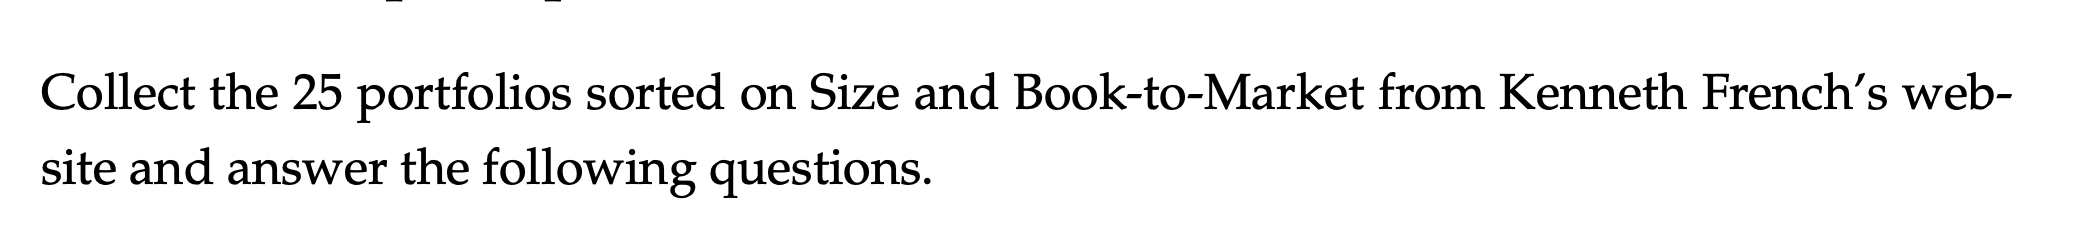

# Data Preprocessing

In [2]:
def read_df(path, sheet):
    """ Read, format, and return the dataframe from the Excel Sheet"""
    df = pd.read_excel(io=path, sheet_name=sheet, header=1)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    if len(str(df['Date'][0])) == 6:
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
    elif len(str(df['Date'][0])) == 4:
        df['Date'] = pd.to_datetime(df['Date'], format='%Y')
    elif len(str(df['Date'][0])) == 8:
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df.set_index('Date', inplace=True)
    return df

def annual_to_monthly(annual_rate):
    return np.exp(annual_rate / 12) - 1

In [3]:
# Path to Data Files
home_dir = r"/Users/talhajamal/Documents/Documents/Imperial/Courses/Semester 2/Empirical Finance/GroupCoursework/"
monthly_portfolios_path = home_dir+"data/25_Portfolios_5x5.xls"
ff3_monthly_path = home_dir+"data/F-F_Research_Data_Factors.xls"

In [4]:
# Monthly Portfolios
ValueWeightedReturnsMonthly = read_df(monthly_portfolios_path, 'dataframe_1')
EqualWeightedReturnsMonthly = read_df(monthly_portfolios_path, 'dataframe_2')

# Convert each DF into correct values
EqualWeightedReturnsMonthly = EqualWeightedReturnsMonthly.apply(annual_to_monthly)
ValueWeightedReturnsMonthly = ValueWeightedReturnsMonthly.apply(annual_to_monthly)

# Monthly Portfolio Characteristics
numOfFirmsPortfoliosMonthly = read_df(monthly_portfolios_path, 'dataframe_5')
avgMarketCapMonthly = read_df(monthly_portfolios_path, 'dataframe_6')

In [5]:
ff3_monthly = read_df(ff3_monthly_path, 'F-F_Research_Data_Factors_Month')
ff3_monthly['RF'] = ff3_monthly['RF'] * 10
ff3_monthly = ff3_monthly.apply(annual_to_monthly)

# Fam Macbeth Regression

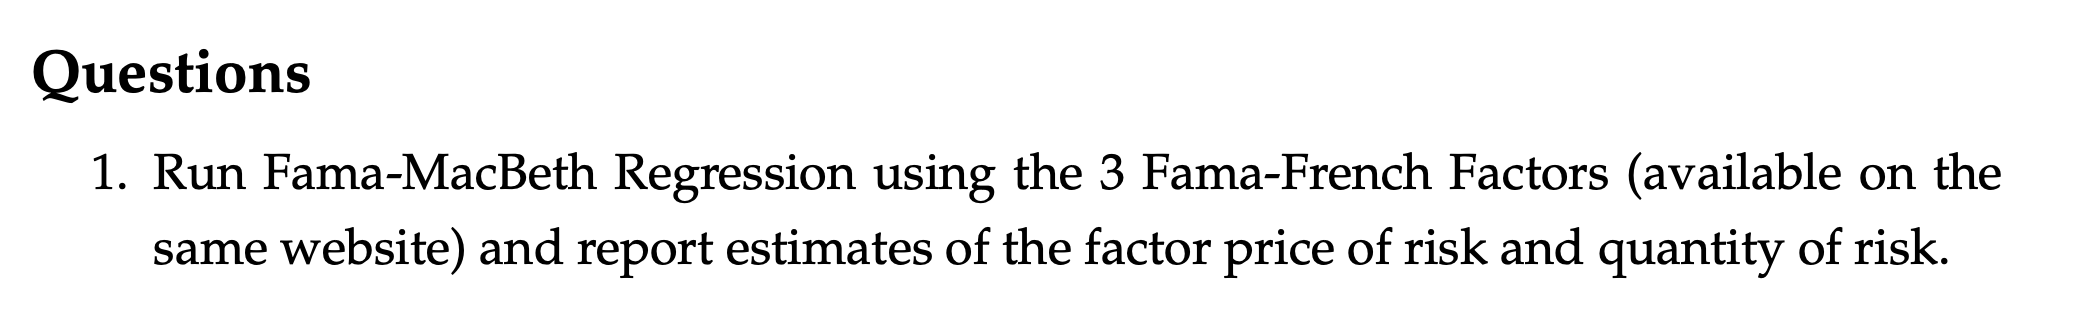

## Functions

In [6]:
def excess_returns_calculation(returns, factors):
    """ Return DF of Excess Returns"""
    excess_returns = returns.subtract(factors['RF'], axis = 0)
    return excess_returns

def time_series_regression(returns, factors):
    """ Run a Time Series Regression of the Excess Returns of the Portfolios on the FF3 Factors
    #factors = sm.add_constant(factors.drop(columns='RF'))
    #reg = sm.OLS(excess_returns, factors).fit()
    #results = reg.params
    #results.columns = returns.columns
    """
    excess_returns = excess_returns_calculation(returns, factors)
    results = {}
    for portfolio in excess_returns:
        reg = sm.OLS(excess_returns[portfolio], sm.add_constant(factors.drop(columns=['RF']))).fit()
        results[portfolio] = reg.params
    return pd.DataFrame(results)

def cross_sectional_regression(ts_regression, returns, factors):
    """ Run a Cross Sectional Regression on the Betas of each Portfolio
        excess_returns = excess_returns_calculation(returns, factors).T
        betas = ts_regression.T.drop(columns=['const'])
        betas_w_const = sm.add_constant(betas)
        reg = sm.OLS(excess_returns, betas_w_const).fit()
        results = reg.params
        results.columns = returns.index
    """
    excess_returns = excess_returns_calculation(returns, factors)
    results = []
    for t in excess_returns.index:
        betas = ts_regression.loc[ts_regression.index != 'const', :].T
        reg = sm.OLS(excess_returns.loc[t], sm.add_constant(betas)).fit()
        results.append(reg.params)    
    return pd.DataFrame(results, index=excess_returns.index)

def FamaMacbethRegression(returns, factors):
    """ Run the Fama Macbeth Regression and return Factor Price Risk and Quantity of Risk"""
    ts_reg = time_series_regression(returns, factors)
    cs_reg = cross_sectional_regression(ts_reg, returns, factors).drop(columns=['const'])
    factor_price_risk = cs_reg.mean()
    quantity_of_risk = cs_reg.var()
    print("The Factor Price of Risk is: ")
    print(factor_price_risk)
    print("The Quantity of Risk is: ")
    print(quantity_of_risk)
    result = {
        'TimeSeriesRegression':ts_reg,
        'CrossSectionalRegression':cs_reg,
        'FactorPriceRisk':factor_price_risk,
        'QuantityOfRisk':quantity_of_risk
    }
    return result

## Run Fama Macbeth for each Portfolio

In [7]:
# Average Equal Weighted Returns Portfolio - Monthly
fm_reg_eq_w_ret_monthly = FamaMacbethRegression(EqualWeightedReturnsMonthly, ff3_monthly)

The Factor Price of Risk is: 
Mkt-RF    0.040566
SMB       0.023859
HML       0.050380
dtype: float64
The Quantity of Risk is: 
Mkt-RF    12.120427
SMB        0.591493
HML        0.789158
dtype: float64


In [8]:
# Average Value Weighted Returns Portfolio - Monthly
fm_reg_val_w_ret_monthly = FamaMacbethRegression(ValueWeightedReturnsMonthly, ff3_monthly)

The Factor Price of Risk is: 
Mkt-RF    0.070847
SMB       0.024909
HML       0.045549
dtype: float64
The Quantity of Risk is: 
Mkt-RF    1.688380
SMB       0.582868
HML       1.188330
dtype: float64


# Augmented Fama Macbeth Regression

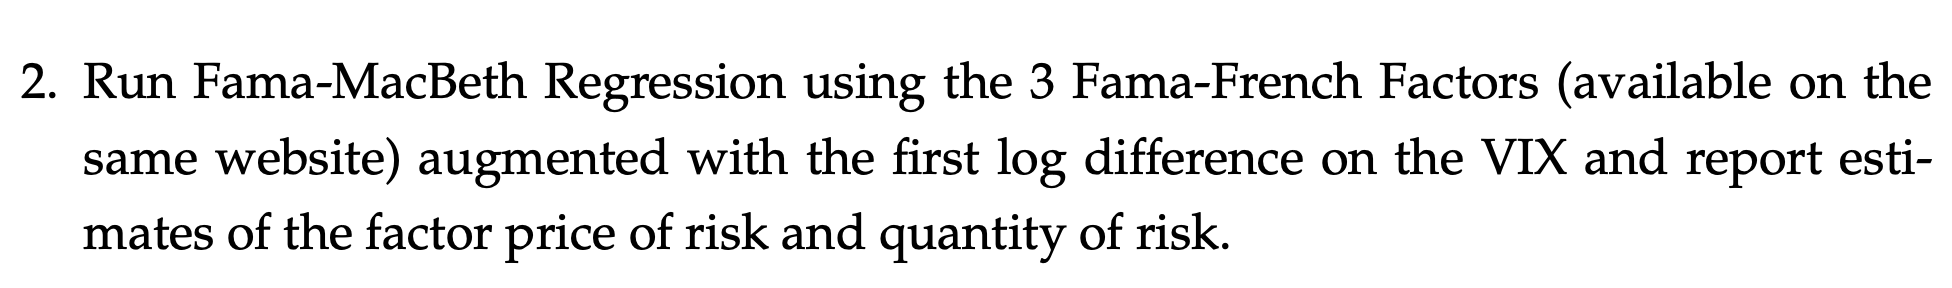

## Import VIX Data

In [9]:
import yfinance as yf

vix_ticker = "^VIX"
vix = yf.Ticker(vix_ticker)
vix_monthly = vix.history(period="max", interval="1mo")  # Monthly VIX data
vix_monthly.index = vix_monthly.index.tz_localize(None)
vix_monthly['Adj Close'] = np.exp(vix_monthly['Close'] / 12) - 1
vix_monthly['Change'] = np.log(vix_monthly['Adj Close']/vix_monthly['Adj Close'].shift(1))
vix_monthly.dropna(inplace=True)
vix_monthly.drop(vix_monthly.index[-1], inplace=True)

## Useful Functions

In [10]:
def synchronize_date_ranges(df1, df2, df3):
    """
    Synchronizes the date ranges of three DataFrames.
    """
    # Determine the latest start date and the earliest end date across the dataframes
    start_date = max(df1.index.min(), df2.index.min(), df3.index.min())
    end_date = min(df1.index.max(), df2.index.max(), df3.index.max())
    
    # Filter or reindex the dataframes to match the common date range
    df1_sync = df1.loc[start_date:end_date]
    df2_sync = df2.loc[start_date:end_date]
    df3_sync = df3.loc[start_date:end_date]
    
    return df1_sync, df2_sync, df3_sync

def AugmentedFamaMacbeth(returns, factors, vix):
    """ Return an Augmented Version of Fama Macbeth Regression by adding 
    the First Log Difference of the VIX as an additional factor """
    returns, factors, VIX = synchronize_date_ranges(returns, factors, vix)
    factors['VIX'] = VIX['Change']
    augmented_fm_reg = FamaMacbethRegression(returns, factors)
    return augmented_fm_reg

## Run Fama Macbeth Regressions

In [11]:
# Run Augmented Fama Macbeth on Value Weighted Monthly Portfolio
aug_fm_reg_val_w_ret_monthly = AugmentedFamaMacbeth(ValueWeightedReturnsMonthly, ff3_monthly, vix_monthly)

/var/folders/z8/18vf272n36z6tx1xm5tv3qvw0000gn/T/ipykernel_43355/2389397716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['VIX'] = VIX['Change']


The Factor Price of Risk is: 
Mkt-RF    0.118951
SMB       0.049711
HML       0.021674
VIX       0.029340
dtype: float64
The Quantity of Risk is: 
Mkt-RF    0.590579
SMB       0.173256
HML       0.207612
VIX       6.865571
dtype: float64


In [12]:
# Run Augmented Fama Macbeth on Equal Weighted Monthly Portfolio
aug_fm_reg_eq_w_ret_monthly = AugmentedFamaMacbeth(EqualWeightedReturnsMonthly, ff3_monthly, vix_monthly)

/var/folders/z8/18vf272n36z6tx1xm5tv3qvw0000gn/T/ipykernel_43355/2389397716.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['VIX'] = VIX['Change']


The Factor Price of Risk is: 
Mkt-RF    0.091759
SMB       0.102922
HML       0.011359
VIX      -0.161549
dtype: float64
The Quantity of Risk is: 
Mkt-RF     1.055879
SMB        0.627126
HML        0.305054
VIX       21.587992
dtype: float64
